# Cochlear Receiver Tests

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
%matplotlib inline
import sys
from pathlib import Path
sys.path.append(str(Path("..") / "src"))

import numpy as np
import matplotlib.pyplot as plt

from config import PhysicsConfig, SpikingRadarConfig
from transmitter import SpikingRadarTransmitter
from receiver import ResonantCochlearReceiver


In [ ]:
# Setup and config

physics_config = PhysicsConfig(wave_type="sound")
model_config = SpikingRadarConfig(
    fs_hz=100_000.0,
    duration_s=0.03,
    chirp_duration_s=0.005,
    chirp_bandwidth_hz=5_000.0,
    chirp_start_hz=1_000.0,
    carrier_hz=20_000.0,
    attenuation=0.5,
    noise_std=0.0,
    threshold=0.5,
    lowpass_cutoff_hz=20_000.0,
    receiver_spacing_m=0.2,
)

receiver = ResonantCochlearReceiver(model_config, n_channels=32)
time_s = model_config.time_vector()


## Unit Test 1: Resonance Check

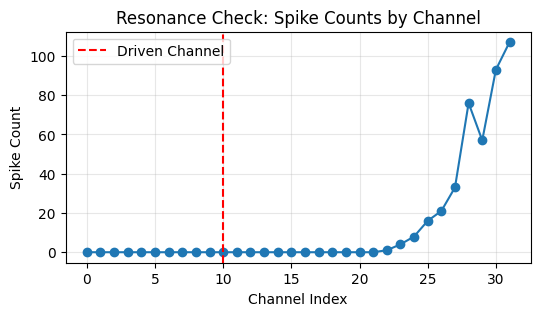

In [23]:
# Drive the channel-3 frequency with a pure tone
channel_idx = 10  # zero-based index (channel 3)
freq_hz = receiver.frequencies_hz[channel_idx]
signal = np.sin(2.0 * np.pi * freq_hz * time_s)

spikes = receiver.process(signal, signal)
spike_counts = spikes["left"].sum(axis=1)

plt.figure(figsize=(6, 3))
plt.plot(spike_counts, marker="o")
plt.axvline(channel_idx, color="red", linestyle="--", label="Driven Channel")
plt.title("Resonance Check: Spike Counts by Channel")
plt.xlabel("Channel Index")
plt.ylabel("Spike Count")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## Unit Test 2: Chirp Response

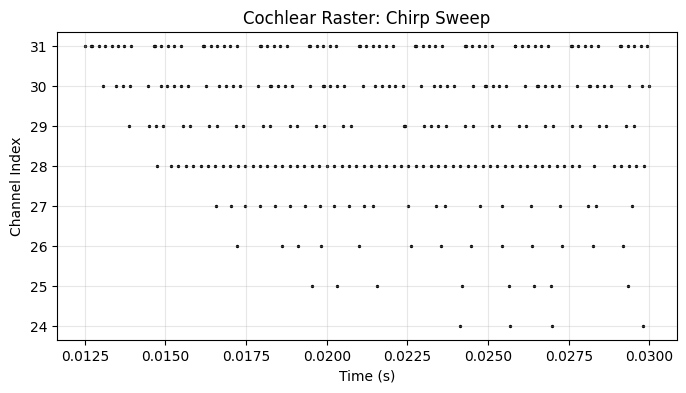

In [12]:
# Pass a modulated chirp through the cochlear receiver
transmitter = SpikingRadarTransmitter(model_config)
tx = transmitter.build()

spikes = receiver.process(tx.tx_signal, tx.tx_signal)
spike_matrix = spikes["left"]

spike_t = []
spike_i = []
for i in range(spike_matrix.shape[0]):
    times = np.flatnonzero(spike_matrix[i])
    spike_t.extend(time_s[times])
    spike_i.extend([i] * len(times))

plt.figure(figsize=(8, 4))
plt.scatter(spike_t, spike_i, s=2, color="black")
plt.title("Cochlear Raster: Chirp Sweep")
plt.xlabel("Time (s)")
plt.ylabel("Channel Index")
plt.grid(True, alpha=0.3)
plt.show()


## Unit Test 3: Binaural Comparison

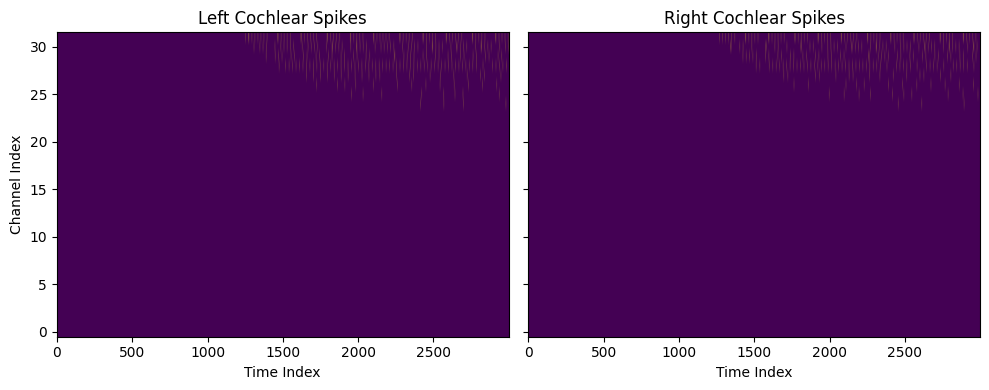

In [6]:
# Apply a small ITD/ILD and compare left/right spike matrices
itd_s = 200e-6
delay_samples = int(round(itd_s * model_config.fs_hz))

right = np.concatenate([np.zeros(delay_samples), tx.tx_signal[:-delay_samples]])
left = tx.tx_signal.copy()
right = 0.8 * right

spikes = receiver.process(left, right)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].imshow(spikes["left"], aspect="auto", origin="lower")
axes[0].set_title("Left Cochlear Spikes")
axes[0].set_xlabel("Time Index")
axes[0].set_ylabel("Channel Index")

axes[1].imshow(spikes["right"], aspect="auto", origin="lower")
axes[1].set_title("Right Cochlear Spikes")
axes[1].set_xlabel("Time Index")

plt.tight_layout()
plt.show()
